# Parametric Court + Dynamic Visualization

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

# Court Parameters (editable)

In [15]:
COURT_DEFAULT = {
    # overall court (NBA is 94 x 50)
    "court_length_ft": 94.0,
    "court_width_ft": 50.0,

    # hoop position: distance from baseline to center of rim
    "hoop_from_baseline_ft": 4.0,

    # 3PT geometry (NBA)
    "three_arc_radius_ft": 23.75,
    "corner_three_dist_ft": 22.0,   # horizontal distance from hoop center to corner 3 line

    # paint (NBA lane is 16ft wide; length is 19ft from baseline to FT line)
    "lane_width_ft": 16.0,
    "lane_length_ft": 19.0,

    # free throw circle radius (6ft)
    "ft_circle_radius_ft": 6.0,

    # restricted area radius (4ft)
    "restricted_radius_ft": 4.0,
}

# Geometry helpers (distance, angle, 3PT test)

In [16]:
def inches_to_feet(x_in):
    return x_in / 12.0

def shot_distance_angle(x_in, y_in):
    """
    NBA shotchart coords: basket at (0,0), x left/right, y toward midcourt.
    Inputs are inches; returns (distance_ft, angle_rad, angle_deg).
    """
    x_ft = inches_to_feet(x_in)
    y_ft = inches_to_feet(y_in)
    dist_ft = np.sqrt(x_ft**2 + y_ft**2)
    ang = np.arctan2(y_ft, x_ft)  # radians
    return dist_ft, ang, np.degrees(ang)

def three_break_y_ft(params):
    """
    Where the straight corner line meets the 3pt arc.
    Solve y = sqrt(R^2 - corner^2).
    """
    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    if R <= c:
        return 0.0
    return np.sqrt(R**2 - c**2)

def is_three_pointer(x_in, y_in, params):
    """
    Returns True if (x,y) is behind the 3PT line under current params.
    Uses NBA-style: straight corner lines up to y_break, then circular arc.
    """
    x_ft = inches_to_feet(x_in)
    y_ft = inches_to_feet(y_in)

    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    yb = three_break_y_ft(params)

    # Corner region: y <= yb -> compare |x| to corner dist
    if y_ft <= yb:
        return abs(x_ft) >= c

    # Above the break: compare radial distance to arc radius
    return (x_ft**2 + y_ft**2) >= (R**2)

def add_shot_features(df, params, x_col="LOC_X", y_col="LOC_Y"):
    """
    Adds distance_ft, angle_deg, is_three (based on params) to a shot dataframe.
    Assumes LOC_X/LOC_Y inches from basket.
    """
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()

    x_ft = x / 12.0
    y_ft = y / 12.0

    dist_ft = np.sqrt(x_ft**2 + y_ft**2)
    angle_deg = np.degrees(np.arctan2(y_ft, x_ft))

    # vectorized 3pt
    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    yb = three_break_y_ft(params)

    in_corner_band = y_ft <= yb
    three_corner = (np.abs(x_ft) >= c) & in_corner_band
    three_arc = ((x_ft**2 + y_ft**2) >= R**2) & (~in_corner_band)
    is_three = three_corner | three_arc

    out = df.copy()
    out["distance_ft_new"] = dist_ft
    out["angle_deg_new"] = angle_deg
    out["is_three_new"] = is_three.astype(int)
    return out

# Fixed Court

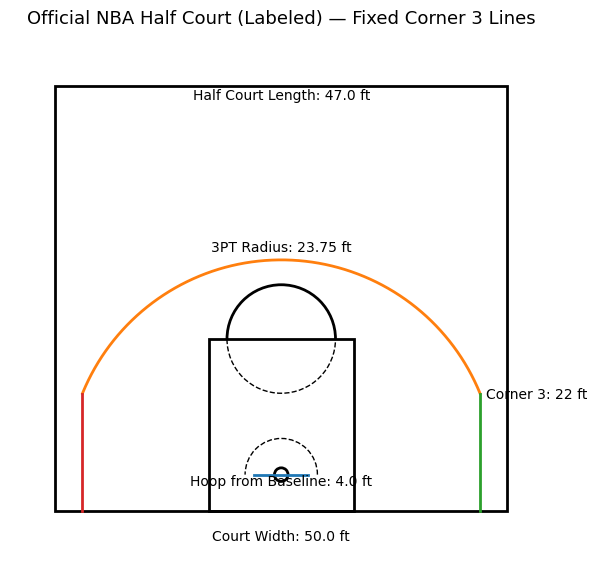

In [17]:
# === Full pasteable cell: Official NBA half-court w/ FIXED corner 3 lines + labeled measurements ===

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

def draw_official_nba_half_court_labeled():
    # -----------------------
    # Official-ish NBA params (feet)
    # -----------------------
    court_width = 50.0
    half_court_length = 47.0          # baseline to half-court line
    hoop_from_baseline = 4.0
    three_arc_radius = 23.75
    corner_three_distance = 22.0      # from hoop centerline (x) to corner 3 line

    # Key areas (approx)
    paint_width = 16.0
    paint_length = 19.0              # baseline to FT line
    backboard_from_baseline = 4.0    # approx location of backboard plane (same as hoop_y here for simple viz)
    backboard_width = 6.0
    rim_radius = 0.75                # 18" diameter => 9" radius => 0.75 ft
    restricted_radius = 4.0

    # -----------------------
    # Setup figure
    # -----------------------
    fig, ax = plt.subplots(figsize=(7, 7))

    # Court boundary (half court)
    ax.add_patch(Rectangle((-court_width/2, 0), court_width, half_court_length,
                           fill=False, linewidth=2))

    # Hoop (rim)
    hoop_x, hoop_y = 0.0, hoop_from_baseline
    ax.add_patch(Circle((hoop_x, hoop_y), rim_radius, fill=False, linewidth=2))

    # Backboard (simple line)
    ax.plot([-backboard_width/2, backboard_width/2], [backboard_from_baseline, backboard_from_baseline], linewidth=2)

    # Paint (lane)
    ax.add_patch(Rectangle((-paint_width/2, 0), paint_width, paint_length,
                           fill=False, linewidth=2))

    # Free throw circle (top half)
    ft_center = (0.0, paint_length)
    ax.add_patch(Arc(ft_center, 12.0, 12.0, angle=0, theta1=0, theta2=180, linewidth=2))
    # Dashed bottom half (NBA style often dashed)
    ax.add_patch(Arc(ft_center, 12.0, 12.0, angle=0, theta1=180, theta2=360, linewidth=1, linestyle="--"))

    # Restricted area arc
    ax.add_patch(Arc((0.0, hoop_y), 2*restricted_radius, 2*restricted_radius,
                     angle=0, theta1=0, theta2=180, linewidth=1, linestyle="--"))

    # -----------------------
    # 3PT arc + FIXED corner lines
    # -----------------------
    R = three_arc_radius

    # Arc endpoints occur where it meets the corner line x = ±corner_x
    corner_x = min(corner_three_distance, (court_width/2) - 0.5)  # keep inside court
    under = R**2 - corner_x**2
    y_corner_end = hoop_y + np.sqrt(under) if under > 0 else hoop_y
    y_corner_end = min(y_corner_end, half_court_length)

    # Draw 3PT arc (only the visible top part that connects corners)
    # Parameterize arc points, then clip to y >= y_corner_end (so it meets corner lines)
    theta = np.linspace(0, np.pi, 600)
    x_arc = hoop_x + R * np.cos(theta)
    y_arc = hoop_y + R * np.sin(theta)

    mask = y_arc >= y_corner_end - 1e-6
    ax.plot(x_arc[mask], y_arc[mask], linewidth=2)

    # Draw corner 3 straight segments at x = ±corner_x from baseline to y_corner_end
    ax.plot([ corner_x,  corner_x], [0, y_corner_end], linewidth=2)
    ax.plot([-corner_x, -corner_x], [0, y_corner_end], linewidth=2)

    # -----------------------
    # Simple measurement labels
    # -----------------------
    ax.text(0, half_court_length - 1.5, f"Half Court Length: {half_court_length:.1f} ft", ha="center")
    ax.text(0, -2.0, f"Court Width: {court_width:.1f} ft", ha="center", va="top")
    ax.text(0, hoop_y + R + 1.0, f"3PT Radius: {R:.2f} ft", ha="center")
    ax.text(corner_x + 0.6, y_corner_end - 0.5, f"Corner 3: {corner_three_distance:.0f} ft", ha="left")
    ax.text(0, hoop_y - 1.2, f"Hoop from Baseline: {hoop_from_baseline:.1f} ft", ha="center")

    # -----------------------
    # Styling
    # -----------------------
    ax.set_aspect("equal")
    ax.set_xlim(-court_width/2 - 5, court_width/2 + 5)
    ax.set_ylim(-5, half_court_length + 6)
    ax.set_title("Official NBA Half Court (Labeled) — Fixed Corner 3 Lines", fontsize=13)
    ax.axis("off")

    plt.show()

draw_official_nba_half_court_labeled()

# Draw a parameterized half-court

In [18]:
def draw_half_court(ax, params, show_labels=False):
    """
    Draw a half court with (0,0) at basket center.
    x in feet left/right; y in feet toward midcourt.
    """
    W = params["court_width_ft"]
    L = params["court_length_ft"]
    hoop_y = 0.0  # basket at y=0 in shot chart coords
    half_court_y = (L / 2.0) - params["hoop_from_baseline_ft"]  # distance from hoop to midcourt

    # boundaries (half court rectangle)
    ax.add_patch(Rectangle((-W/2, -params["hoop_from_baseline_ft"]), W, half_court_y + params["hoop_from_baseline_ft"],
                           fill=False, linewidth=2))

    # hoop
    ax.add_patch(Circle((0, hoop_y), radius=0.75, fill=False, linewidth=2))  # rim radius ~0.75ft (18in)

    # backboard (approx)
    ax.add_patch(Rectangle((-3, -1.0), 6, 0.1, fill=False, linewidth=2))

    # restricted area
    ax.add_patch(Arc((0, 0), 2*params["restricted_radius_ft"], 2*params["restricted_radius_ft"],
                     theta1=0, theta2=180, linewidth=2))

    # paint (lane)
    lane_w = params["lane_width_ft"]
    lane_l = params["lane_length_ft"]
    ax.add_patch(Rectangle((-lane_w/2, -params["hoop_from_baseline_ft"]), lane_w, lane_l + params["hoop_from_baseline_ft"],
                           fill=False, linewidth=2))

    # free throw circle
    ft_y = lane_l  # from hoop coords, FT line is at y=19ft (NBA)
    r = params["ft_circle_radius_ft"]
    ax.add_patch(Arc((0, ft_y), 2*r, 2*r, theta1=0, theta2=180, linewidth=2))
    ax.add_patch(Arc((0, ft_y), 2*r, 2*r, theta1=180, theta2=360, linewidth=2, linestyle="dashed"))

    # 3PT line: corner segments + arc
    R = params["three_arc_radius_ft"]
    c = params["corner_three_dist_ft"]
    yb = three_break_y_ft(params)

    # corner lines (from baseline up to yb)
    ax.plot([ c,  c], [-params["hoop_from_baseline_ft"], yb], linewidth=2)
    ax.plot([-c, -c], [-params["hoop_from_baseline_ft"], yb], linewidth=2)

    # arc (from left break to right break)
    # Compute angles where x = +/- c on circle radius R
    if R > c:
        theta = np.degrees(np.arccos(c / R))
        # arc should span from (180-theta) to theta (in matplotlib Arc coords)
        ax.add_patch(Arc((0, 0), 2*R, 2*R, theta1=theta, theta2=180-theta, linewidth=2))

    # formatting
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-W/2 - 2, W/2 + 2)
    ax.set_ylim(-params["hoop_from_baseline_ft"] - 2, half_court_y + 2)
    ax.axis("off")

    if show_labels:
        ax.text(0, half_court_y + 1, f"Half-court Y max ≈ {half_court_y:.1f} ft", ha="center")
        ax.text(0, -params["hoop_from_baseline_ft"] - 1.5, "Baseline", ha="center")

# Static test plot (make sure geometry looks right)

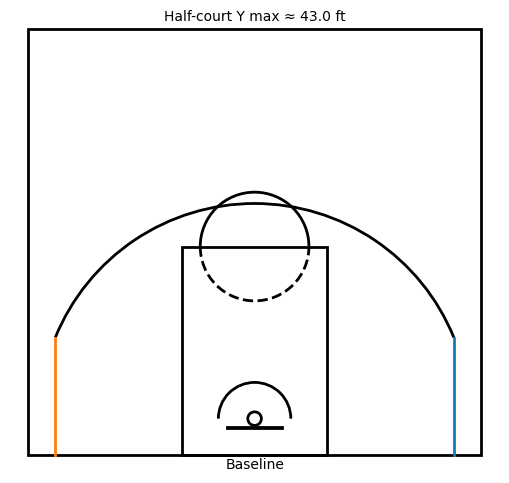

In [19]:
fig, ax = plt.subplots(figsize=(7,6))
draw_half_court(ax, COURT_DEFAULT, show_labels=True)
plt.show()

interactive(children=(FloatSlider(value=23.75, description='three_arc_radius_ft', max=40.0, min=15.0, step=0.5…

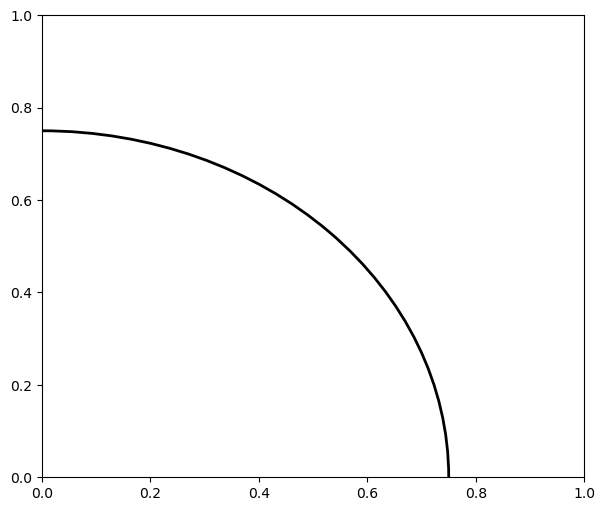

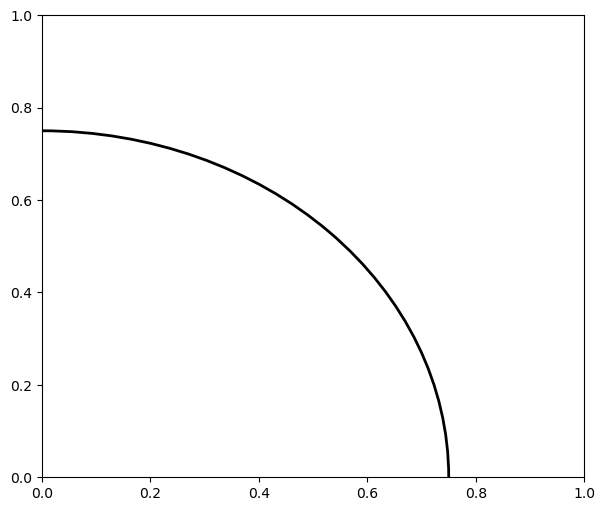

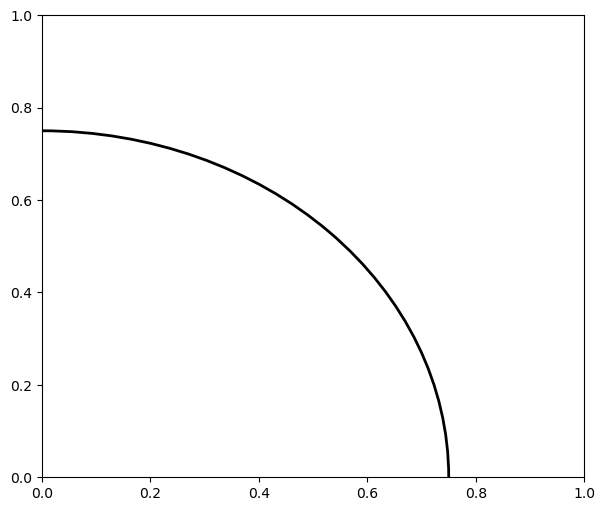

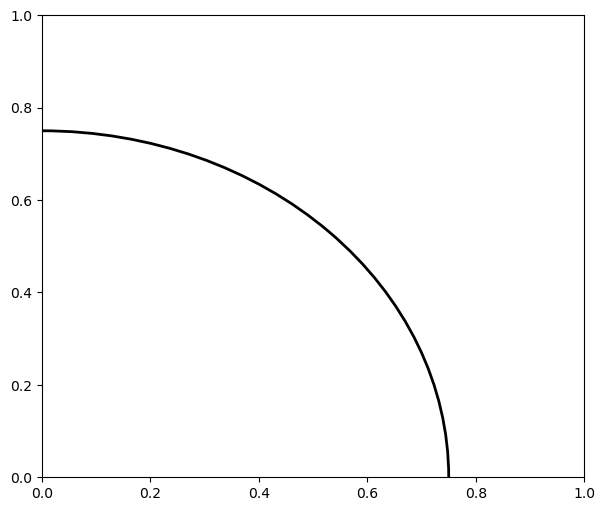

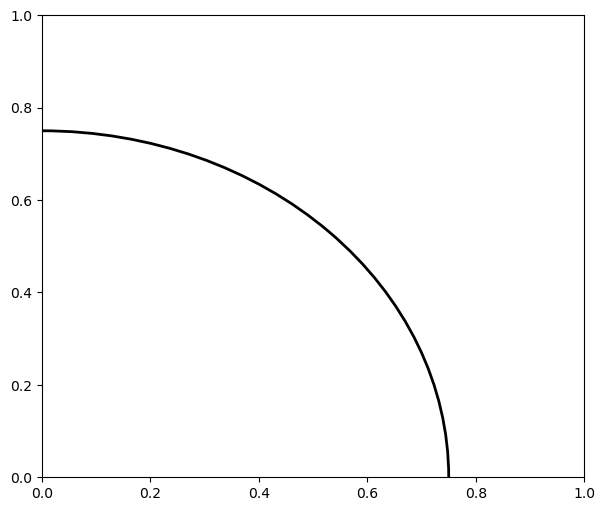

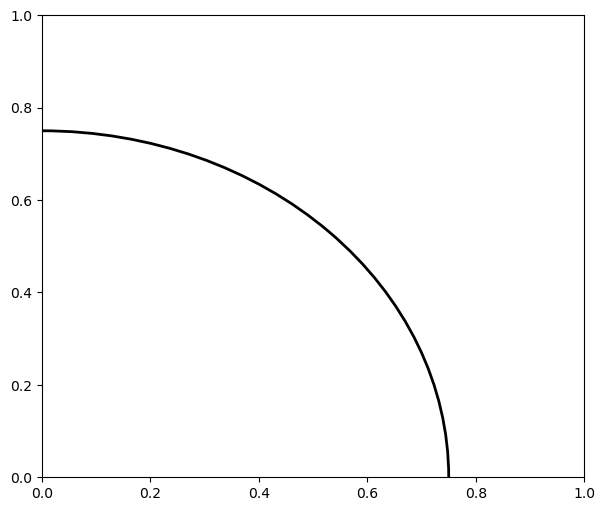

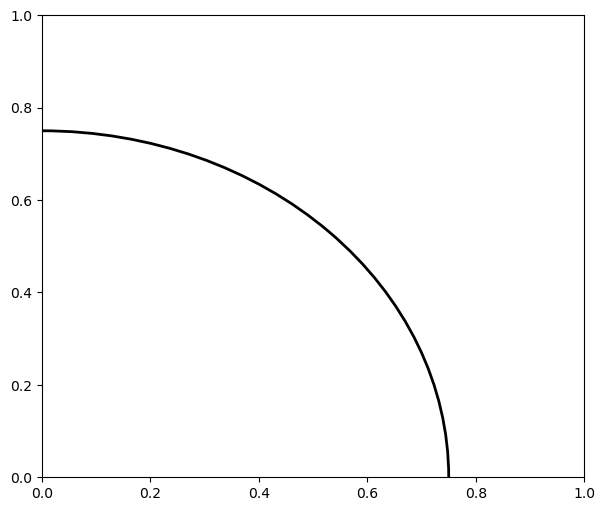

In [20]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# --- MUST be defined BEFORE interact() ---
COURT_DEFAULT = {
    "court_width_ft": 50.0,
    "court_length_ft": 94.0,
    "hoop_from_baseline_ft": 4.0,
    "three_arc_radius_ft": 23.75,
    "corner_three_dist_ft": 22.0,
    "lane_width_ft": 16.0,
    "lane_length_ft": 19.0,
    "ft_circle_radius_ft": 6.0,
    "restricted_radius_ft": 4.0,
}

def interactive_court(
    three_arc_radius_ft=23.75,
    corner_three_dist_ft=22.0,
    court_width_ft=50.0,
    court_length_ft=94.0,
    hoop_from_baseline_ft=4.0,
):
    # copy defaults then override slider params
    params = dict(COURT_DEFAULT)
    params["three_arc_radius_ft"] = three_arc_radius_ft
    params["corner_three_dist_ft"] = corner_three_dist_ft
    params["court_width_ft"] = court_width_ft
    params["court_length_ft"] = court_length_ft
    params["hoop_from_baseline_ft"] = hoop_from_baseline_ft

    fig, ax = plt.subplots(figsize=(7, 6))
    # NOTE: draw_half_court(ax, params) must already exist from your earlier cells
    draw_half_court(ax, params)

    ax.set_title(
        f"3PT arc={three_arc_radius_ft:.2f}ft | corner={corner_three_dist_ft:.2f}ft | "
        f"court={court_length_ft:.1f}x{court_width_ft:.1f} | hoop baseline={hoop_from_baseline_ft:.1f}ft"
    )
    plt.show()

interact(
    interactive_court,
    three_arc_radius_ft=FloatSlider(min=15.0, max=40.0, step=0.5, value=23.75),
    corner_three_dist_ft=FloatSlider(min=15.0, max=35.0, step=0.5, value=22.0),
    court_width_ft=FloatSlider(min=30.0, max=80.0, step=1.0, value=50.0),
    court_length_ft=FloatSlider(min=60.0, max=140.0, step=2.0, value=94.0),
    hoop_from_baseline_ft=FloatSlider(min=1.0, max=12.0, step=0.5, value=4.0),
);


# Load CSV + Convert Coordinates + Court Drawing Helpers

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

# =========
# 1) Load your master CSV
# =========
CSV_PATH = "MASTER_NBA_DF_FINALS_ONLY - MASTER_NBA_DF_FINALS_ONLY.csv"
shots = pd.read_csv(CSV_PATH)

# Basic column sanity check
required_cols = ["PLAYER_NAME", "LOC_X", "LOC_Y", "SHOT_MADE_FLAG"]
missing = [c for c in required_cols if c not in shots.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# =========
# 2) Court parameters (feet) — keep consistent with your CourtGeometry notebook
#    (These are the standard NBA values you’ve been using.)
# =========
COURT = {
    "court_width_ft": 50.0,
    "court_length_ft": 94.0,
    "hoop_from_baseline_ft": 4.0,     # rim center is 4 ft from baseline
    "three_arc_radius_ft": 23.75,     # top-of-arc radius (from rim)
    "corner_three_dist_ft": 22.0,     # corner 3 distance (from rim horizontally at corner line)
    "lane_width_ft": 16.0,            # paint width
    "lane_length_ft": 19.0,           # baseline to FT line
    "ft_circle_radius_ft": 6.0,
    "restricted_radius_ft": 4.0,
    "backboard_y_from_baseline_ft": 4.0,  # rim y also ~4; board is slightly behind rim, but ok visually
}

# =========
# 3) Coordinate conversion
# NBA API LOC_X/LOC_Y are commonly in "tenths of feet" with origin at the RIM:
#   rim is (0,0)
#   LOC_X left(-)/right(+)
#   LOC_Y toward midcourt(+)
#
# Your court drawing uses baseline y=0, so we shift +hoop_from_baseline_ft
# =========
def api_to_court_xy(loc_x, loc_y, hoop_from_baseline_ft=COURT["hoop_from_baseline_ft"]):
    x_ft = loc_x / 10.0
    y_ft = (loc_y / 10.0) + hoop_from_baseline_ft
    return x_ft, y_ft

shots["X_FT"], shots["Y_FT"] = api_to_court_xy(shots["LOC_X"], shots["LOC_Y"])

# =========
# 4) Court drawing (HALF COURT) aligned to your coordinate system
# - baseline is y=0
# - hoop is at y=hoop_from_baseline_ft
# - centered width around x=0 ([-25, +25])
# =========
def draw_fixed_half_court(ax, params=COURT, lw=2):
    W = params["court_width_ft"]
    L = params["court_length_ft"]
    half_L = L / 2.0

    hoop_y = params["hoop_from_baseline_ft"]
    three_r = params["three_arc_radius_ft"]
    corner_dist = params["corner_three_dist_ft"]

    lane_w = params["lane_width_ft"]
    lane_l = params["lane_length_ft"]
    ft_r = params["ft_circle_radius_ft"]
    rr_r = params["restricted_radius_ft"]

    # Outer half-court boundary (baseline to half-court line)
    ax.add_patch(Rectangle((-W/2, 0), W, half_L, fill=False, linewidth=lw))

    # Hoop (rim) + restricted area
    ax.add_patch(Circle((0, hoop_y), radius=0.75, fill=False, linewidth=lw))  # rim radius ~0.75ft
    ax.add_patch(Arc((0, hoop_y), 2*rr_r, 2*rr_r, theta1=0, theta2=180, linewidth=lw))

    # Backboard (simple line)
    ax.plot([-3, 3], [hoop_y-1, hoop_y-1], linewidth=lw)

    # Paint (lane)
    ax.add_patch(Rectangle((-lane_w/2, 0), lane_w, lane_l, fill=False, linewidth=lw))

    # Free throw circle (top solid, bottom dashed)
    ft_center = (0, lane_l)
    ax.add_patch(Arc(ft_center, 2*ft_r, 2*ft_r, theta1=0, theta2=180, linewidth=lw))
    ax.add_patch(Arc(ft_center, 2*ft_r, 2*ft_r, theta1=180, theta2=360, linewidth=lw, linestyle="--"))

    # 3PT corner lines:
    # Find y where the arc intersects the corner distance:
    # corner_dist^2 + (y - hoop_y)^2 = three_r^2  -> y = hoop_y + sqrt(three_r^2 - corner_dist^2)
    y_corner_intersect = hoop_y + np.sqrt(max(0.0, three_r**2 - corner_dist**2))

    # vertical corner lines from baseline to intersection point
    ax.plot([ W/2 - (W/2 - corner_dist),  W/2 - (W/2 - corner_dist)], [0, y_corner_intersect], linewidth=lw)
    ax.plot([-W/2 + (W/2 - corner_dist), -W/2 + (W/2 - corner_dist)], [0, y_corner_intersect], linewidth=lw)

    # 3PT arc (exclude the corner line portions)
    # Compute angle where arc hits corner line:
    # x = corner_dist = r*cos(theta)  -> theta = arccos(corner_dist/r)
    theta = np.degrees(np.arccos(corner_dist / three_r))
    # arc from left to right (symmetric)
    ax.add_patch(Arc((0, hoop_y), 2*three_r, 2*three_r, theta1=theta, theta2=180-theta, linewidth=lw))

    # Midcourt circle (optional in half court)
    ax.add_patch(Arc((0, half_L), 12, 12, theta1=180, theta2=360, linewidth=lw))

    # Ax formatting
    ax.set_aspect("equal")
    ax.set_xlim(-W/2 - 2, W/2 + 2)
    ax.set_ylim(-1, half_L + 2)
    ax.axis("off")


# Toggle Player Name + Plot O (make) / X (miss) on the Fixed Court

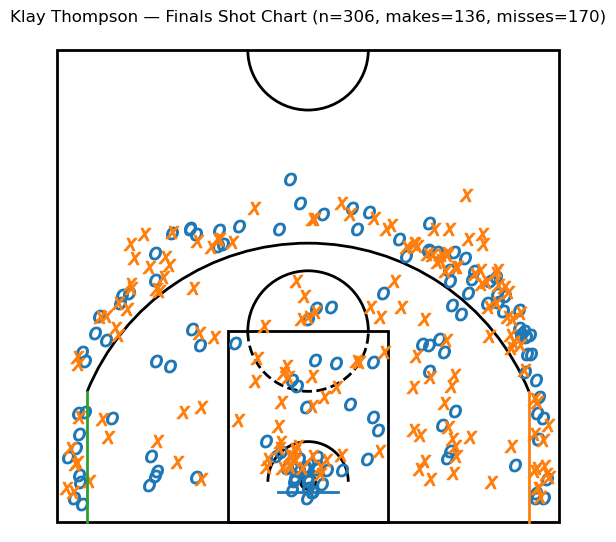

In [22]:
# =========
# Toggle this one line to switch players
# =========
PLAYER_NAME = "Klay Thompson"   # <-- change this to anyone in shots["PLAYER_NAME"]

# Filter player shots
p = shots[shots["PLAYER_NAME"] == PLAYER_NAME].copy()
if p.empty:
    available = sorted(shots["PLAYER_NAME"].dropna().unique().tolist())
    raise ValueError(f"No rows found for PLAYER_NAME='{PLAYER_NAME}'. Example available names: {available[:15]} ...")

# Split makes/misses
makes = p[p["SHOT_MADE_FLAG"] == 1]
misses = p[p["SHOT_MADE_FLAG"] == 0]

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
draw_fixed_half_court(ax)

# Use text markers so it literally looks like O and X
# (These render as markers, not annotations, so they’re still fast.)
ax.scatter(makes["X_FT"], makes["Y_FT"], marker="$O$", s=80)
ax.scatter(misses["X_FT"], misses["Y_FT"], marker="$X$", s=80)

# Title + quick info
n_total = len(p)
n_makes = len(makes)
ax.set_title(f"{PLAYER_NAME} — Finals Shot Chart (n={n_total}, makes={n_makes}, misses={n_total-n_makes})")

plt.show()

# Attempts Heatmap (Exhaustive Search)

In [23]:
# === 500x500 grid + a(r)/b(r) attempt probabilities (uses CSV shot locations) ===
# Assumes you already have:
#   - a dataframe called `shots` loaded from your CSV
#   - columns: PLAYER_NAME, LOC_X, LOC_Y, SHOT_MADE_FLAG (optional for later)
#   - OR columns: PLAYER_NAME, X_FT, Y_FT already created
#
# Coordinate convention this cell uses (matches what you were doing earlier):
#   x_ft = LOC_X / 10
#   y_ft = LOC_Y / 10 + hoop_from_baseline_ft
#   baseline is y=0, hoop center is (0, hoop_from_baseline_ft)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# -------------------------
# 0) COURT DEFAULTS (edit if needed)
# -------------------------
COURT_DEFAULT = {
    "court_width_ft": 50.0,
    "court_length_ft": 94.0,          # full court
    "hoop_from_baseline_ft": 4.0,      # hoop center y from baseline
    "three_arc_radius_ft": 23.75,      # NBA arc radius
    "corner_three_dist_ft": 22.0,      # horizontal distance hoop->corner line
}

# -------------------------
# 1) Make sure we have X_FT / Y_FT from the CSV LOC_X/LOC_Y
# -------------------------
def ensure_xy_ft(df, court_params):
    df = df.copy()
    if "X_FT" not in df.columns:
        if "LOC_X" not in df.columns:
            raise ValueError("Need LOC_X in shots dataframe (or precomputed X_FT).")
        df["X_FT"] = df["LOC_X"] / 10.0
    if "Y_FT" not in df.columns:
        if "LOC_Y" not in df.columns:
            raise ValueError("Need LOC_Y in shots dataframe (or precomputed Y_FT).")
        df["Y_FT"] = df["LOC_Y"] / 10.0 + float(court_params["hoop_from_baseline_ft"])
    return df

# -------------------------
# 2) 3PT boundary test (inside = 2PT region, outside = 3PT region)
# -------------------------
def inside_three_boundary(x_ft, y_ft, court_params):
    """
    Returns True if (x_ft, y_ft) is INSIDE the 3PT line (i.e., in 2PT region).
    court coords: baseline y=0, hoop at (0, hoop_y).
    """
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    r = float(court_params["three_arc_radius_ft"])
    c = float(court_params["corner_three_dist_ft"])

    # Safety: if corner distance is >= radius, arc can't connect; treat everything by circle.
    if c >= r:
        return (x_ft**2 + (y_ft - hoop_y)**2) <= r**2

    # y where corner line meets arc
    y_int = hoop_y + np.sqrt(max(r**2 - c**2, 0.0))

    if y_ft <= y_int:
        return abs(x_ft) <= c
    else:
        return (x_ft**2 + (y_ft - hoop_y)**2) <= r**2

# -------------------------
# 3) Build a 500x500 grid over HALF COURT + map shots -> cells
# -------------------------
def compute_grid_counts(player_df, court_params, grid_n=500):
    W = float(court_params["court_width_ft"])
    L = float(court_params["court_length_ft"]) / 2.0  # half court length

    # grid edges
    x_edges = np.linspace(-W/2, W/2, grid_n + 1)
    y_edges = np.linspace(0.0, L, grid_n + 1)

    # histogram2d expects x, y; returns shape (nx, ny) by default if you pass x then y
    H, _, _ = np.histogram2d(player_df["X_FT"].to_numpy(), player_df["Y_FT"].to_numpy(),
                             bins=[x_edges, y_edges])

    # H shape is (grid_n, grid_n) for x-bins by y-bins
    return H, x_edges, y_edges

def grid_cell_centers(x_edges, y_edges):
    x_cent = (x_edges[:-1] + x_edges[1:]) / 2.0
    y_cent = (y_edges[:-1] + y_edges[1:]) / 2.0
    Xc, Yc = np.meshgrid(x_cent, y_cent, indexing="ij")  # same indexing as H (x first)
    return Xc, Yc

# -------------------------
# 4) Compute a(r), b(r) from the grid for one player
# -------------------------
def compute_a_b_from_grid(H, Xc, Yc, court_params):
    total = H.sum()
    if total <= 0:
        return 0.0, 0.0, np.zeros_like(H)

    P = H / total  # probability mass per cell, sum(P)=1

    # inside mask for EACH cell center
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    r = float(court_params["three_arc_radius_ft"])
    c = float(court_params["corner_three_dist_ft"])

    # vectorized inside-three test
    if c >= r:
        inside = (Xc**2 + (Yc - hoop_y)**2) <= r**2
    else:
        y_int = hoop_y + np.sqrt(max(r**2 - c**2, 0.0))
        inside = np.where(
            Yc <= y_int,
            (np.abs(Xc) <= c),
            (Xc**2 + (Yc - hoop_y)**2) <= r**2
        )

    a = float(P[inside].sum())         # inside arc+corner (2PT region)
    b = float(1.0 - a)                 # outside (3PT region)
    return a, b, P

# -------------------------
# 5) Simple fixed half-court drawer (uses your parameters)
#     (If you already have draw_fixed_half_court(ax) in your notebook, you can replace this.)
# -------------------------
from matplotlib.patches import Rectangle, Circle, Arc

def draw_fixed_half_court(ax, court_params):
    W = float(court_params["court_width_ft"])
    L = float(court_params["court_length_ft"]) / 2.0
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    r = float(court_params["three_arc_radius_ft"])
    c = float(court_params["corner_three_dist_ft"])

    # Court outline
    ax.add_patch(Rectangle((-W/2, 0), W, L, fill=False, linewidth=2))

    # Hoop + backboard (simple)
    ax.add_patch(Circle((0, hoop_y), 0.75, fill=False, linewidth=2))
    ax.plot([-3, 3], [hoop_y + 0.6, hoop_y + 0.6], linewidth=2)

    # Paint (16 ft wide, 19 ft deep)
    lane_w = 16.0
    lane_len = 19.0
    ax.add_patch(Rectangle((-lane_w/2, 0), lane_w, lane_len, fill=False, linewidth=2))

    # FT circle (6 ft radius)
    ax.add_patch(Arc((0, lane_len), 12, 12, theta1=0, theta2=180, linewidth=2))
    ax.add_patch(Arc((0, lane_len), 12, 12, theta1=180, theta2=360, linewidth=1, linestyle="--"))

    # Restricted circle (4 ft radius)
    ax.add_patch(Arc((0, hoop_y), 8, 8, theta1=0, theta2=180, linewidth=2))

    # 3PT corner lines + arc
    if c < r:
        y_int = hoop_y + np.sqrt(max(r**2 - c**2, 0.0))
    else:
        y_int = hoop_y

    # Corner lines (vertical)
    ax.plot([-c, -c], [0, min(y_int, L)], linewidth=3)
    ax.plot([ c,  c], [0, min(y_int, L)], linewidth=3)

    # Arc (top portion)
    # draw from left intersection to right intersection
    if c < r:
        theta = np.degrees(np.arccos(c / r))
        ax.add_patch(Arc((0, hoop_y), 2*r, 2*r, theta1=theta, theta2=180-theta, linewidth=2))

    ax.set_xlim(-W/2 - 2, W/2 + 2)
    ax.set_ylim(0 - 1, L + 2)
    ax.set_aspect("equal")
    ax.axis("off")

# -------------------------
# 6) Plot attempts as MARKERS on grid cells + report a(r), b(r)
# -------------------------
def plot_player_grid_attempts(shots_df, player_name, court_params, grid_n=500,
                              min_cell_count=1, size_scale=8.0, title_extra=""):
    dfp = shots_df[shots_df["PLAYER_NAME"] == player_name].copy()
    if dfp.empty:
        raise ValueError(f"No rows for PLAYER_NAME='{player_name}'")

    H, x_edges, y_edges = compute_grid_counts(dfp, court_params, grid_n=grid_n)
    Xc, Yc = grid_cell_centers(x_edges, y_edges)
    a, b, P = compute_a_b_from_grid(H, Xc, Yc, court_params)

    # only plot cells with enough attempts
    mask = H >= min_cell_count
    xs = Xc[mask].ravel()
    ys = Yc[mask].ravel()
    counts = H[mask].ravel()

    # marker sizes: scale with sqrt so it doesn’t explode
    sizes = size_scale * np.sqrt(counts)

    fig, ax = plt.subplots(figsize=(7, 7))
    draw_fixed_half_court(ax, court_params)

    ax.scatter(xs, ys, s=sizes, marker="s", alpha=0.8)  # squares = grid cells

    total = int(H.sum())
    ax.set_title(
        f"{player_name} — 500x500 Cell Attempts (n={total})\n"
        f"a(r)=P(inside 3PT boundary)= {a:.3f}   |   b(r)=P(outside)= {b:.3f}   (a+b=1)"
        + (f"\n{title_extra}" if title_extra else "")
    )
    plt.show()

    return {"player": player_name, "total_attempts": total, "a_r": a, "b_r": b}

# -------------------------
# 7) INTERACTIVE: change arc radius r and corner distance live + recompute a(r), b(r)
# -------------------------
def interactive_player_attempt_grid(player_name,
                                    three_arc_radius_ft=COURT_DEFAULT["three_arc_radius_ft"],
                                    corner_three_dist_ft=COURT_DEFAULT["corner_three_dist_ft"],
                                    grid_n=500,
                                    min_cell_count=1):

    court_params = dict(COURT_DEFAULT)
    court_params["three_arc_radius_ft"] = float(three_arc_radius_ft)
    court_params["corner_three_dist_ft"] = float(corner_three_dist_ft)

    return plot_player_grid_attempts(
        shots, player_name, court_params,
        grid_n=int(grid_n),
        min_cell_count=int(min_cell_count),
        size_scale=7.0,
        title_extra=f"r={three_arc_radius_ft:.2f} ft, corner={corner_three_dist_ft:.2f} ft"
    )

# -------------------------
# 8) RUN THIS (toggle PLAYER_NAME)
# -------------------------
# Make sure `shots` exists in your notebook:
# shots = pd.read_csv("MASTER_NBA_DF_FINALS_ONLY - MASTER_NBA_DF_FINALS_ONLY.csv")
shots = ensure_xy_ft(shots, COURT_DEFAULT)

PLAYER_NAME = "Klay Thompson"   # <-- change this to switch players

interact(
    lambda three_arc_radius_ft, corner_three_dist_ft: interactive_player_attempt_grid(
        PLAYER_NAME,
        three_arc_radius_ft=three_arc_radius_ft,
        corner_three_dist_ft=corner_three_dist_ft,
        grid_n=500,
        min_cell_count=1
    ),
    three_arc_radius_ft=FloatSlider(min=18.0, max=32.0, step=0.25, value=COURT_DEFAULT["three_arc_radius_ft"]),
    corner_three_dist_ft=FloatSlider(min=18.0, max=28.0, step=0.25, value=COURT_DEFAULT["corner_three_dist_ft"]),
);


interactive(children=(FloatSlider(value=23.75, description='three_arc_radius_ft', max=32.0, min=18.0, step=0.2…

In [ ]:
# ============================================================
# ML Stepback Tendency + Predicted Attempt Map when r changes
# (uses X_FT, Y_FT + PLAYER_NAME; corner fixed; r editable)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import Dropdown, FloatText, Button, HBox, VBox, Output, Checkbox
from IPython.display import display

# --- Optional: sklearn logistic regression (recommended) ---
_HAS_SKLEARN = True
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
except Exception:
    _HAS_SKLEARN = False

# --- Optional: gaussian smoothing ---
_HAS_SCIPY = True
try:
    from scipy.ndimage import gaussian_filter
except Exception:
    _HAS_SCIPY = False


# ------------------------------------------------------------
# 0) ASSUMPTIONS / REQUIRED OBJECTS
# ------------------------------------------------------------
# You must have a dataframe called `shots` already loaded, with:
#   - PLAYER_NAME
#   - X_FT, Y_FT   (feet; your fixed-court coordinates)
#
# You must have a half-court drawing function already in your notebook:
#   draw_fixed_half_court(ax, court_params)  OR draw_fixed_half_court(ax)
# This cell calls it robustly.

required = ["PLAYER_NAME", "X_FT", "Y_FT"]
missing = [c for c in required if c not in shots.columns]
if missing:
    raise ValueError(f"`shots` is missing required columns: {missing}")

# Court defaults (match your notebook if you already defined COURT_DEFAULT)
if "COURT_DEFAULT" not in globals():
    COURT_DEFAULT = {
        "court_width_ft": 50.0,
        "court_length_ft": 94.0,
        "hoop_from_baseline_ft": 4.0,  # rim center is 4 ft from baseline
        "three_arc_radius_ft": 23.75,  # baseline NBA
        "corner_three_dist_ft": 22.0,  # FIXED corners per your request
    }

# ------------------------------------------------------------
# 1) Helpers: robust court draw + signed distance to 3PT boundary
# ------------------------------------------------------------
def _draw_half_court_robust(ax, court_params):
    """
    Calls your existing draw function with or without court_params,
    so we don't crash depending on your signature.
    """
    for name in ["draw_fixed_half_court", "draw_half_court", "draw_halfcourt"]:
        if name in globals() and callable(globals()[name]):
            fn = globals()[name]
            try:
                fn(ax, court_params)
                return
            except TypeError:
                try:
                    fn(ax)
                    return
                except TypeError:
                    pass

    # Fallback (very minimal outline if no draw function exists)
    W = float(court_params["court_width_ft"])
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    half_l = float(court_params["court_length_ft"]) / 2.0
    ax.plot([-W/2, -W/2], [0, half_l], lw=2)
    ax.plot([ W/2,  W/2], [0, half_l], lw=2)
    ax.plot([-W/2,  W/2], [0, 0], lw=2)
    ax.plot([-W/2,  W/2], [half_l, half_l], lw=2)
    ax.scatter([0], [hoop_y], s=30)
    ax.set_aspect("equal")
    ax.axis("off")


def signed_distance_to_3pt_boundary(x, y, r, corner_dist, hoop_y):
    """
    Signed distance to the 3PT line boundary:
      negative => inside (2PT side)
      positive => outside (3PT side)
    Piecewise: corner lines for low y; arc elsewhere.

    Our half-court coordinates assumed:
      hoop at (0, hoop_y) where hoop_y ~ 4
      baseline at y=0
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Corner boundary is vertical at |x| = corner_dist (for low y region).
    # Arc boundary is circle centered at hoop: sqrt(x^2 + (y-hoop_y)^2) = r
    # We blend with a hard switch at the join height where the circle meets the corner line.
    inside_val = r*r - corner_dist*corner_dist
    y_join = hoop_y + np.sqrt(np.maximum(inside_val, 0.0))  # where arc meets corner line

    d_corner = np.abs(x) - corner_dist
    rho = np.sqrt(x*x + (y - hoop_y)*(y - hoop_y))
    d_arc = rho - r

    use_corner = (y <= y_join)
    return np.where(use_corner, d_corner, d_arc)


def attempt_band_mask(d_r0, delta_ft):
    """Shots within +/- delta_ft of the 3PT boundary (baseline line r0)."""
    return np.abs(d_r0) <= float(delta_ft)


# ------------------------------------------------------------
# 2) ML: train per-player "outside probability" near the line
# ------------------------------------------------------------
def make_features(x, y, d):
    """
    Features for logistic model.
    - x,y capture location
    - d captures signed distance to boundary (this is what changes with r)
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    d = np.asarray(d, float)
    return np.column_stack([
        d,
        x, y,
        x*y,
        x*x, y*y,
        np.abs(x), np.abs(d),
    ])


def fit_stepback_model_for_player(df_player, court_params, delta_ft=2.0):
    """
    Train logistic regression on shots in a band around baseline 3PT line (r0),
    labeling outside vs inside at r0.

    Returns:
      model (pipeline), baseline band mask, d_r0 (all shots), y_label (band)
    """
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    r0 = float(court_params["three_arc_radius_ft"])
    corner = float(court_params["corner_three_dist_ft"])

    x = df_player["X_FT"].to_numpy()
    y = df_player["Y_FT"].to_numpy()

    d0 = signed_distance_to_3pt_boundary(x, y, r0, corner, hoop_y)
    band = attempt_band_mask(d0, delta_ft)

    # If player has too few band shots, we fall back later
    if band.sum() < 15 or not _HAS_SKLEARN:
        return None, band, d0, None

    y_label = (d0[band] > 0).astype(int)  # 1 = outside (3-side), 0 = inside (2-side)
    X = make_features(x[band], y[band], d0[band])

    # Regularized logistic regression
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            C=1.0,
            penalty="l2",
            solver="lbfgs",
            max_iter=2000,
        )
    )
    model.fit(X, y_label)
    return model, band, d0, y_label


# ------------------------------------------------------------
# 3) Counterfactual prediction when r changes (Δr model)
# ------------------------------------------------------------
def predict_stepback_probabilities(df_player, model, court_params, r_new, delta_ft=2.0):
    """
    For each shot in the *band around baseline line*, compute probability it will be outside
    under the *new* line by swapping d := d_r_new in the feature vector.
    """
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    r0 = float(court_params["three_arc_radius_ft"])
    corner = float(court_params["corner_three_dist_ft"])

    x = df_player["X_FT"].to_numpy()
    y = df_player["Y_FT"].to_numpy()

    d0 = signed_distance_to_3pt_boundary(x, y, r0, corner, hoop_y)
    band = attempt_band_mask(d0, delta_ft)

    d_new = signed_distance_to_3pt_boundary(x, y, float(r_new), corner, hoop_y)

    if model is None:
        # Fallback heuristic: probability depends on how far beyond the NEW line the shot is
        # (steeper => more "stepback willing"). This still changes with r.
        k = 2.5
        p_out = 1.0 / (1.0 + np.exp(-k * d_new[band]))
        return band, d0, d_new, p_out

    X_new = make_features(x[band], y[band], d_new[band])
    p_out = model.predict_proba(X_new)[:, 1]
    return band, d0, d_new, p_out


def displaced_locations_for_counterfactual(df_player, court_params, r_new, delta_ft,
                                           p_out_band, band_mask, d0_all):
    """
    Create a "probable new map" by nudging band shots along the radial direction.
    Intuition when line moves back (Δr>0):
      - borderline 3s with low stepback propensity shift inward (avoid longer 3)
      - borderline 2s with high stepback propensity shift outward (become 3)
    """
    r0 = float(court_params["three_arc_radius_ft"])
    hoop_y = float(court_params["hoop_from_baseline_ft"])

    x = df_player["X_FT"].to_numpy().astype(float)
    y = df_player["Y_FT"].to_numpy().astype(float)

    dx = x.copy()
    dy = y.copy()

    dr = float(r_new) - r0
    if np.isclose(dr, 0.0):
        return dx, dy

    # radial unit vector from hoop -> shot
    vx = x
    vy = y - hoop_y
    norm = np.sqrt(vx*vx + vy*vy) + 1e-9
    ux = vx / norm
    uy = vy / norm

    band_idx = np.where(band_mask)[0]
    # p_out_band: probability of being outside under NEW line for these band shots
    p = np.clip(np.asarray(p_out_band), 0.0, 1.0)

    # Which side at baseline?
    is3_baseline = (d0_all[band_idx] > 0).astype(float)  # 1 if baseline 3-side

    # If line moves back (dr>0):
    # - baseline 3s: shift inward by dr * (1 - p)  (avoid deeper 3)
    # - baseline 2s: shift outward by dr * p      (step back to keep 3)
    # If line moves in (dr<0): reverse incentives (smaller shift magnitude)
    if dr > 0:
        shift = dr * ( (1.0 - is3_baseline) * p  - is3_baseline * (1.0 - p) )
    else:
        # dr < 0 (line closer): outside becomes easier; many 2s may drift outward less necessary,
        # so we damp a bit.
        shift = dr * 0.6 * ( (1.0 - is3_baseline) * p  - is3_baseline * (1.0 - p) )

    # Cap extreme shifts so we don't teleport shots
    shift = np.clip(shift, -2.5, 2.5)

    dx[band_idx] = x[band_idx] + shift * ux[band_idx]
    dy[band_idx] = y[band_idx] + shift * uy[band_idx]
    return dx, dy


# ------------------------------------------------------------
# 4) Heatmap utility (white->red) from points
# ------------------------------------------------------------
def attempt_density_heatmap(x, y, court_params, gridsize=220, sigma=2.0, min_count=1):
    """
    Returns a density image (normalized 0..1) for imshow.
    """
    W = float(court_params["court_width_ft"])
    half_l = float(court_params["court_length_ft"]) / 2.0

    x = np.asarray(x, float)
    y = np.asarray(y, float)

    # Histogram over half court bounds
    xb = (-W/2, W/2)
    yb = (0, half_l)

    H, xedges, yedges = np.histogram2d(x, y, bins=gridsize, range=[xb, yb])
    H = H.T  # for imshow

    # Mask low counts to keep white space
    H[H < min_count] = 0.0

    # Smooth if possible
    if _HAS_SCIPY and sigma and sigma > 0:
        H = gaussian_filter(H, sigma=float(sigma))

    if H.max() > 0:
        H = H / H.max()

    # convert zeros to NaN so they render white via set_bad
    H = H.astype(float)
    H[H == 0] = np.nan
    extent = [xb[0], xb[1], yb[0], yb[1]]
    return H, extent


# ------------------------------------------------------------
# 5) Interactive view: observed attempts + predicted map
# ------------------------------------------------------------
out = Output()

player_list = sorted(shots["PLAYER_NAME"].dropna().unique().tolist())
player_dd = Dropdown(options=player_list, value=player_list[0], description="Player:")

r_in = FloatText(value=float(COURT_DEFAULT["three_arc_radius_ft"]), description="Arc r:")
delta_in = FloatText(value=2.0, description="δ band ft:")
sigma_in = FloatText(value=2.2, description="smooth σ:")
show_table = Checkbox(value=False, description="Show (a,b) for all players")

reset_btn = Button(description="Reset r", button_style="danger")
def _on_reset(_):
    r_in.value = float(COURT_DEFAULT["three_arc_radius_ft"])
reset_btn.on_click(_on_reset)


def compute_a_b_for_player(df_player, court_params, r_value):
    hoop_y = float(court_params["hoop_from_baseline_ft"])
    corner = float(court_params["corner_three_dist_ft"])
    x = df_player["X_FT"].to_numpy()
    y = df_player["Y_FT"].to_numpy()
    d = signed_distance_to_3pt_boundary(x, y, float(r_value), corner, hoop_y)
    b = float((d > 0).mean())  # outside = 3-side share
    a = 1.0 - b
    return a, b


def update(*_):
    with out:
        out.clear_output(wait=True)

        p = str(player_dd.value)
        r_new = float(r_in.value)
        delta = float(delta_in.value)
        sigma = float(sigma_in.value)

        # fixed-corner params (corner stays at baseline)
        court_params = dict(COURT_DEFAULT)
        r0 = float(court_params["three_arc_radius_ft"])
        corner = float(court_params["corner_three_dist_ft"])
        hoop_y = float(court_params["hoop_from_baseline_ft"])

        dfp = shots.loc[shots["PLAYER_NAME"] == p, ["PLAYER_NAME", "X_FT", "Y_FT"]].dropna().copy()
        if dfp.empty:
            print(f"No rows found for {p}")
            return

        # baseline a,b at r0
        a0, b0 = compute_a_b_for_player(dfp, court_params, r0)

        # train model
        model, band_mask, d0_all, y_label = fit_stepback_model_for_player(dfp, court_params, delta_ft=delta)

        # compute new a,b using geometry at r_new (pure counting, no ML)
        a_geom, b_geom = compute_a_b_for_player(dfp, court_params, r_new)

        # ML stepback probabilities for band shots under new r
        band_mask2, d0_all2, dnew_all, p_out_band = predict_stepback_probabilities(
            dfp, model, court_params, r_new=r_new, delta_ft=delta
        )

        # displaced points (counterfactual map)
        x_cf, y_cf = displaced_locations_for_counterfactual(
            dfp, court_params, r_new=r_new, delta_ft=delta,
            p_out_band=p_out_band, band_mask=band_mask2, d0_all=d0_all2
        )

        # Predicted a,b from ML for band shots:
        # Use true baseline non-band shots as fixed; band shots probabilistic.
        # b_ml = (outside_nonband + sum(p_out_band)) / N
        x = dfp["X_FT"].to_numpy()
        y = dfp["Y_FT"].to_numpy()
        d0 = signed_distance_to_3pt_boundary(x, y, r0, corner, hoop_y)
        nonband = ~attempt_band_mask(d0, delta)
        outside_nonband = float((dnew_all[nonband] > 0).sum())  # geometric under new r for non-band
        b_ml = (outside_nonband + float(np.sum(p_out_band))) / float(len(dfp))
        a_ml = 1.0 - b_ml

        # ---- Plots ----
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Left: observed attempts (fixed court)
        _draw_half_court_robust(axs[0], court_params)
        axs[0].scatter(dfp["X_FT"], dfp["Y_FT"], s=10, alpha=0.75)
        axs[0].set_title(f"Observed attempts (fixed court)\n{p} | n={len(dfp)}")

        # Right: predicted attempt density (white->red) after changing r
        _draw_half_court_robust(axs[1], court_params)

        dens, extent = attempt_density_heatmap(
            x_cf, y_cf, court_params, gridsize=240, sigma=sigma, min_count=1
        )

        cmap = plt.cm.Reds.copy()
        cmap.set_bad(color="white")  # NaNs -> white

        im = axs[1].imshow(
            dens,
            origin="lower",
            extent=extent,
            cmap=cmap,
            alpha=0.95,
            interpolation="bilinear",
            vmin=0.0,
            vmax=1.0
        )
        axs[1].set_title(f"Predicted attempt density after changing r\nr={r_new:.2f} ft (Δd model)")
        cbar = plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
        cbar.set_label("Relative attempt density (normalized)")

        plt.show()

        # ---- Text outputs ----
        print(f"{p} | total_attempts={len(dfp)}")
        print(f"baseline (r0={r0:.2f}):  a0={a0:.3f}  b0={b0:.3f}  (a+b=1)")
        print(f"geometry @ r={r_new:.2f}: a={a_geom:.3f}  b={b_geom:.3f}  (pure boundary reclassification)")
        if model is None and _HAS_SKLEARN:
            print("NOTE: too few band shots for ML; using sigmoid fallback on d(r).")
        elif not _HAS_SKLEARN:
            print("NOTE: sklearn not available; using sigmoid fallback on d(r).")
        print(f"ML-adjusted @ r={r_new:.2f}: a_ml={a_ml:.3f}  b_ml={b_ml:.3f}  (band probabilistic, a+b=1)")

        if show_table.value:
            rows = []
            for name in player_list:
                dfi = shots.loc[shots["PLAYER_NAME"] == name, ["X_FT","Y_FT"]].dropna()
                if len(dfi) == 0:
                    continue
                ai, bi = compute_a_b_for_player(dfi.assign(PLAYER_NAME=name), court_params, r_new)
                rows.append([name, len(dfi), ai, bi])
            tab = pd.DataFrame(rows, columns=["PLAYER_NAME", "n", "a(r)", "b(r)"]).sort_values("b(r)", ascending=False)
            display(tab)


# Wire updates
for w in [player_dd, r_in, delta_in, sigma_in, show_table]:
    w.observe(update, names="value")

display(VBox([
    HBox([player_dd, r_in, reset_btn]),
    HBox([delta_in, sigma_in, show_table]),
    out
]))

update()


# 1. Court Geometry and Coordinate System

We represent the half-court in a fixed coordinate system measured in feet:

- $x_{\text{ft}}$ : horizontal location  
- $y_{\text{ft}}$ : vertical location (distance from baseline)

We discretize the half-court into a $500 \times 500$ grid.

Let the court span:

$$
x \in [x_{\min}, x_{\max}], 
\qquad
y \in [y_{\min}, y_{\max}]
$$

Each shot at $(x,y)$ is assigned to a grid cell:

$$
i = \left\lfloor 
500 \cdot \frac{x - x_{\min}}{x_{\max} - x_{\min}}
\right\rfloor
$$

$$
j = \left\lfloor 
500 \cdot \frac{y - y_{\min}}{y_{\max} - y_{\min}}
\right\rfloor
$$

Let $N_p(i,j)$ be the number of attempts by player $p$ in cell $(i,j)$.

The full attempt map for player $p$ is:

$$
\{N_p(i,j)\}
$$

---

# 2. Defining the 3PT Boundary via Signed Distance

Let $r$ denote the three-point arc radius (in feet).

Define the signed distance function:

$$
d_r(x,y)
$$

with sign convention:

$$
d_r(x,y) < 0 
\quad \Rightarrow \quad 
\text{inside the 3PT line (2PT region)}
$$

$$
d_r(x,y) > 0 
\quad \Rightarrow \quad 
\text{outside the 3PT line (3PT region)}
$$

Define the three-point indicator:

$$
\mathbb{1}_{\text{3PT}}(x,y; r) =
\begin{cases}
1 & \text{if } d_r(x,y) > 0 \\
0 & \text{if } d_r(x,y) \le 0
\end{cases}
$$

---

# 3. Attempt Probabilities $a_p(r)$ and $b_p(r)$

For player $p$, let their attempts be:

$$
\{(x_k, y_k)\}_{k=1}^{n_p}
$$

### Three-point attempt share

$$
b_p(r)
=
\frac{1}{n_p}
\sum_{k=1}^{n_p}
\mathbb{1}_{\text{3PT}}(x_k, y_k; r)
$$

### Two-point attempt share

$$
a_p(r) = 1 - b_p(r)
$$

Thus the normalization condition holds:

$$
a_p(r) + b_p(r) = 1
$$

---

## Boundary Band (Redistribution Region)

When the arc moves from $r$ to $r'$, only shots near the boundary are expected to change.

Define a boundary band of width $\delta$:

$$
\mathcal{B}_r(\delta)
=
\left\{
(x,y) \;:\;
|d_r(x,y)| \le \delta
\right\}
$$

Shots outside this band remain stable.  
Shots inside this band are candidates for redistribution.

# 4. Learning Stepback Propensity via Machine Learning

For each shot in the boundary band near the three-point line, define a binary label:

$$
y =
\begin{cases}
1 & \text{if shot is outside the 3PT line} \\
0 & \text{if shot is inside the 3PT line}
\end{cases}
$$

---

## Logistic Regression Model

We train a logistic regression model to learn each player's tendency to remain on the 3PT side when near the boundary:

$$
\Pr(y = 1 \mid \boldsymbol{\phi})
=
\sigma(\mathbf{w}^\top \boldsymbol{\phi})
$$

where the sigmoid function is

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

and $\boldsymbol{\phi}$ is the feature vector describing each shot.

---

## Feature Vector

The feature vector $\boldsymbol{\phi}$ includes:

- **Signed distance to the 3PT boundary:**
  $$
  d_r(x,y)
  $$

- **Raw location features:**
  $$
  x,\; y
  $$

- **Interaction terms:**
  $$
  x^2,\; y^2,\; xy
  $$

- **Distance magnitude from boundary:**
  $$
  |d_r(x,y)|
  $$

Here:

- $d_r(x,y) < 0$ → shot is inside the arc (2PT region)  
- $d_r(x,y) > 0$ → shot is outside the arc (3PT region)  

This model learns the probability that a player chooses to stay on the 3PT side when positioned near the arc.

We define the learned **stepback propensity** as:

$$
s_p(r)
=
\Pr(\text{outside} \mid \text{player } p,\; r)
$$

This replaces the hand-tuned sigmoid used earlier and grounds the redistribution in data.

---

# 5. Counterfactual When the Arc Moves

Suppose the three-point radius changes from $r$ to $r'$.

### Step 1: Recompute signed distances

$$
d_{r'}(x,y)
$$

### Step 2: Recompute outside probabilities

$$
\Pr(\text{outside at } r')
=
\sigma(\mathbf{w}^\top \boldsymbol{\phi}_{r'})
$$

where $\boldsymbol{\phi}_{r'}$ uses the updated signed distances.

---

## Updated Three-Point Share

The new three-point attempt probability becomes:

$$
b_p(r')
=
\mathbb{E}
\left[
\Pr(\text{outside at } r')
\right]
$$

and

$$
a_p(r') = 1 - b_p(r')
$$

Thus,

$$
a_p(r') + b_p(r') = 1
$$

is preserved by construction.

---

## Interpretation

- Players with high learned $s_p(r)$ (e.g., elite shooters) maintain or increase their 3PT share when the arc moves.
- Players with low $s_p(r)$ shift attempts inward when $r$ increases.
- The redistribution is probabilistic, continuous, and data-driven.
- The model provides


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import Dropdown, IntText, FloatText, Checkbox, HBox, VBox, Output
try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# -----------------------------
# Fixed current-NBA 3PT params
# -----------------------------
R_DEFAULT = 23.75           # arc radius (ft)
CORNER_DEFAULT = 22.0       # corner 3 distance from centerline (ft)
HOOP_Y_DEFAULT = 4.0        # rim center from baseline (ft)

# Court plotting bounds (match your fixed-court notebook)
X_MIN, X_MAX = -25.0, 25.0
Y_MIN, Y_MAX = 0.0, 47.0

MAKE_COL_CANDIDATES = ["MAKE", "made", "SHOT_MADE_FLAG", "FGM", "is_make", "SHOT_MADE"]

def _find_make_col(df: pd.DataFrame) -> str:
    for c in MAKE_COL_CANDIDATES:
        if c in df.columns:
            return c
    raise ValueError(f"Couldn't find a make column. Tried {MAKE_COL_CANDIDATES}. "
                     f"Columns: {list(df.columns)}")

def _make01(series: pd.Series) -> np.ndarray:
    s = series
    if s.dtype == bool:
        return s.astype(int).to_numpy()
    if s.dtype == object:
        lower = s.astype(str).str.lower()
        return lower.map(lambda v: 1 if v in ["made","make","1","true","t","yes","y"] else 0).fillna(0).astype(int).to_numpy()
    return pd.to_numeric(s, errors="coerce").fillna(0).astype(int).to_numpy()

# -------------------------------------------------------
# Signed distance to NBA 3PT boundary (current court)
# d_r(x,y) > 0  => outside (3PT region)
# d_r(x,y) <= 0 => inside  (2PT region)
# -------------------------------------------------------
def signed_distance_to_3pt_boundary(x, y, r=R_DEFAULT, corner_dist=CORNER_DEFAULT, hoop_y=HOOP_Y_DEFAULT):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # join height where corner line meets the arc
    inside_term = np.maximum(r**2 - corner_dist**2, 0.0)
    y_join = hoop_y + np.sqrt(inside_term)

    # distance to corner vertical line (|x| = corner_dist)
    d_corner = np.abs(x) - corner_dist

    # distance to arc circle centered at (0, hoop_y)
    rho = np.sqrt(x**2 + (y - hoop_y)**2)
    d_arc = rho - r

    # use corner distance for points below the join height, else use arc
    use_corner = (y <= y_join)
    return np.where(use_corner, d_corner, d_arc)

def is_outside_3pt(x, y, r=R_DEFAULT, corner_dist=CORNER_DEFAULT, hoop_y=HOOP_Y_DEFAULT):
    return signed_distance_to_3pt_boundary(x, y, r, corner_dist, hoop_y) > 0

# -----------------------------------------
# 500x500 per-cell success probability map
# -----------------------------------------
def success_grid_500(df_player: pd.DataFrame, grid_n=500, min_attempts=2, sigma=1.6,
                     region_mask=None):
    """
    region_mask:
      - None -> use all shots
      - np.ndarray bool same length as df_player -> filter shots
    Returns prob grid (FG%), attempts grid, x_edges, y_edges
    """
    make_col = _find_make_col(df_player)
    m = _make01(df_player[make_col])

    x = df_player["X_FT"].to_numpy(dtype=float)
    y = df_player["Y_FT"].to_numpy(dtype=float)

    if region_mask is not None:
        region_mask = np.asarray(region_mask, dtype=bool)
        x = x[region_mask]; y = y[region_mask]; m = m[region_mask]

    x_edges = np.linspace(X_MIN, X_MAX, grid_n + 1)
    y_edges = np.linspace(Y_MIN, Y_MAX, grid_n + 1)

    att, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
    mk,  _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=m)

    with np.errstate(divide="ignore", invalid="ignore"):
        prob = mk / att
    prob[att < min_attempts] = np.nan

    # Smooth makes and attempts separately then re-divide (stable)
    if sigma and sigma > 0 and _HAS_SCIPY:
        att_s = gaussian_filter(np.nan_to_num(att, nan=0.0), sigma=sigma)
        mk_s  = gaussian_filter(np.nan_to_num(mk,  nan=0.0), sigma=sigma)
        with np.errstate(divide="ignore", invalid="ignore"):
            prob_s = mk_s / att_s
        prob_s[att_s < min_attempts] = np.nan
        prob = prob_s

    return prob, att, x_edges, y_edges

def draw_3pt_boundary(ax, r=R_DEFAULT, corner_dist=CORNER_DEFAULT, hoop_y=HOOP_Y_DEFAULT, lw=2):
    # draw corner verticals and arc
    # join height
    y_join = hoop_y + np.sqrt(max(r**2 - corner_dist**2, 0.0))
    # corners
    ax.plot([ corner_dist,  corner_dist], [Y_MIN, y_join], lw=lw)
    ax.plot([-corner_dist, -corner_dist], [Y_MIN, y_join], lw=lw)
    # arc
    theta = np.linspace(np.arccos(corner_dist / r), np.pi - np.arccos(corner_dist / r), 400)
    x_arc = r * np.cos(theta)
    y_arc = hoop_y + r * np.sin(theta)
    ax.plot(x_arc, y_arc, lw=lw)

def plot_success_maps(shots: pd.DataFrame, player: str, grid_n=500, min_attempts=2, sigma=1.6,
                      show_split=True):
    dfp = shots[shots["PLAYER_NAME"] == player].copy()
    if len(dfp) == 0:
        raise ValueError(f"No rows for player='{player}'")

    make_col = _find_make_col(dfp)
    m = _make01(dfp[make_col])

    x = dfp["X_FT"].to_numpy(dtype=float)
    y = dfp["Y_FT"].to_numpy(dtype=float)

    outside = is_outside_3pt(x, y, r=R_DEFAULT, corner_dist=CORNER_DEFAULT, hoop_y=HOOP_Y_DEFAULT)
    inside  = ~outside

    # attempt shares
    n = len(dfp)
    a = inside.mean()
    b = outside.mean()

    # success probs (conditional make rates)
    a_s = m[inside].mean() if inside.any() else np.nan
    b_s = m[outside].mean() if outside.any() else np.nan

    # overall FG% heatmap
    prob_all, att_all, x_edges, y_edges = success_grid_500(dfp, grid_n=grid_n, min_attempts=min_attempts, sigma=sigma)

    if show_split:
        prob_in,  _, _, _ = success_grid_500(dfp, grid_n=grid_n, min_attempts=min_attempts, sigma=sigma, region_mask=inside)
        prob_out, _, _, _ = success_grid_500(dfp, grid_n=grid_n, min_attempts=min_attempts, sigma=sigma, region_mask=outside)

        fig, axs = plt.subplots(1, 3, figsize=(16.5, 6.2))
        titles = [
            "FG% per cell (all shots)",
            "FG% per cell (inside 3PT)",
            "FG% per cell (outside 3PT)"
        ]
        probs = [prob_all, prob_in, prob_out]
    else:
        fig, axs = plt.subplots(1, 1, figsize=(7.5, 6.5))
        axs = [axs]
        titles = ["FG% per cell (all shots)"]
        probs = [prob_all]

    cmap = plt.cm.Reds.copy()
    cmap.set_bad(color="white")

    for ax, title, prob in zip(axs, titles, probs):
        im = ax.imshow(
            prob.T,
            origin="lower",
            extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
            cmap=cmap,
            vmin=0.0, vmax=1.0,
            interpolation="bilinear",
            alpha=0.95
        )

        # If you have your own court drawing function, call it here too.
        # draw_fixed_half_court(ax)
        draw_3pt_boundary(ax, r=R_DEFAULT, corner_dist=CORNER_DEFAULT, hoop_y=HOOP_Y_DEFAULT, lw=2)

        ax.set_title(title)
        ax.set_aspect("equal")
        ax.axis("off")

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label("Estimated make probability (FG%)")

    fig.suptitle(
        f"{player} — Current Court (r={R_DEFAULT}, corner={CORNER_DEFAULT})\n"
        f"attempt shares: a(r)={a:.3f} (inside), b(r)={b:.3f} (outside), a+b=1\n"
        f"success probs: a^s(r)={a_s:.3f} (make|inside), b^s(r)={b_s:.3f} (make|outside)  [NOT expected to sum to 1]",
        y=1.02, fontsize=12
    )
    plt.tight_layout()
    plt.show()

    return {
        "player": player,
        "n": int(n),
        "a(r)_inside_share": float(a),
        "b(r)_outside_share": float(b),
        "a^s(r)_make_given_inside": float(a_s) if np.isfinite(a_s) else np.nan,
        "b^s(r)_make_given_outside": float(b_s) if np.isfinite(b_s) else np.nan,
    }

# ---------------------------------------------------
# Table for EVERY player: a(r), b(r), a^s(r), b^s(r)
# ---------------------------------------------------
def compute_all_players_success_splits(shots: pd.DataFrame):
    make_col = _find_make_col(shots)
    rows = []
    for p, dfp in shots.groupby("PLAYER_NAME"):
        x = dfp["X_FT"].to_numpy(dtype=float)
        y = dfp["Y_FT"].to_numpy(dtype=float)
        m = _make01(dfp[make_col])
        outside = is_outside_3pt(x, y, r=R_DEFAULT, corner_dist=CORNER_DEFAULT, hoop_y=HOOP_Y_DEFAULT)
        inside = ~outside
        n = len(dfp)
        a = inside.mean() if n else np.nan
        b = outside.mean() if n else np.nan
        a_s = m[inside].mean() if inside.any() else np.nan
        b_s = m[outside].mean() if outside.any() else np.nan
        rows.append([p, n, a, b, a_s, b_s])
    tab = pd.DataFrame(rows, columns=["PLAYER_NAME","n","a(r)","b(r)","a^s(r)","b^s(r)"])
    return tab.sort_values("n", ascending=False).reset_index(drop=True)

# -------------------------
# Interactive viewer
# -------------------------
players = sorted(shots["PLAYER_NAME"].dropna().unique().tolist())
player_dd = Dropdown(options=players, value=players[0], description="Player:")
grid_in   = IntText(value=500, description="grid:", layout={"width":"180px"})
min_in    = IntText(value=2, description="min:", layout={"width":"180px"})
sig_in    = FloatText(value=1.6, description="sigma:", layout={"width":"180px"})
split_cb  = Checkbox(value=True, description="Show split maps (inside/outside)")
out = Output()

def _update(*_):
    with out:
        out.clear_output(wait=True)
        summary = plot_success_maps(
            shots,
            player=player_dd.value,
            grid_n=int(grid_in.value),
            min_attempts=int(min_in.value),
            sigma=float(sig_in.value),
            show_split=bool(split_cb.value)
        )
        display(pd.DataFrame([summary]))

player_dd.observe(_update, names="value")
grid_in.observe(_update, names="value")
min_in.observe(_update, names="value")
sig_in.observe(_update, names="value")
split_cb.observe(_update, names="value")

display(VBox([
    HBox([player_dd, grid_in, min_in, sig_in, split_cb]),
    out
]))
_update()

# Compute and display the full table (every player)
all_players_tab = compute_all_players_success_splits(shots)
display(all_players_tab)


,PLAYER_NAME,n,a(r),b(r),a^s(r),b^s(r)
0,Stephen Curry,448,0.468750,0.531250,0.480952,0.399160
1,LeBron James,325,0.738462,0.261538,0.625000,0.388235
2,Klay Thompson,306,0.464052,0.535948,0.450704,0.439024
3,Jayson Tatum,218,0.623853,0.376147,0.382353,0.365854
4,Kevin Durant,189,0.666667,0.333333,0.579365,0.476190
5,Jimmy Butler III,188,0.829787,0.170213,0.512821,0.343750
6,Draymond Green,186,0.602151,0.397849,0.508929,0.229730
7,Jrue Holiday,164,0.670732,0.329268,0.454545,0.351852
8,Devin Booker,143,0.713287,0.286713,0.529412,0.268293
9,Bam Adebayo,142,0.992958,0.007042,0.482270,0.000000


In [ ]:
import os
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# ------------------------------------------------------------
# Assumptions:
#  - shots exists
#  - COURT_DEFAULT exists and includes "three_arc_radius_ft"
#  - compute_ppg_table_for_r(shots, r, court_params=COURT_DEFAULT) exists
# ------------------------------------------------------------

R_DEFAULT = float(COURT_DEFAULT.get("three_arc_radius_ft", 23.75))
R_MIN = 18.0
R_MAX = 40.0
R_STEP = 0.25

# Cache for exporting (filled after "Compute ALL")
_ALL_R_DF = None

r_slider = widgets.FloatSlider(
    value=R_DEFAULT, min=R_MIN, max=R_MAX, step=R_STEP,
    description="r", readout=True, continuous_update=False,
    layout=widgets.Layout(width="420px")
)

btn_minus = widgets.Button(description="-0.25", layout=widgets.Layout(width="90px"))
btn_plus  = widgets.Button(description="+0.25", layout=widgets.Layout(width="90px"))
btn_reset = widgets.Button(description=f"Reset r={R_DEFAULT:.2f}", layout=widgets.Layout(width="140px"))

btn_show_current = widgets.Button(description="Show current table", button_style="info",
                                  layout=widgets.Layout(width="170px"))
btn_compute_all = widgets.Button(description="Compute ALL r (23.75→40)", button_style="warning",
                                 layout=widgets.Layout(width="220px"))

btn_export_csv = widgets.Button(description="Export ALL as CSV", button_style="success",
                                layout=widgets.Layout(width="170px"))

status = widgets.HTML(value="")
out = widgets.Output()

def _clamp_r(x):
    x = round(x / R_STEP) * R_STEP
    return float(np.clip(x, R_MIN, R_MAX))

def _render_current_table(r):
    df = compute_ppg_table_for_r(shots, r=r, court_params=COURT_DEFAULT).copy()

    if "predicted_ppg_with_different_r" in df.columns:
        df = df.sort_values("predicted_ppg_with_different_r", ascending=False).reset_index(drop=True)

    if "r" not in df.columns:
        df.insert(0, "r", r)
    else:
        df["r"] = r

    status.value = f"<b>Current r:</b> {r:.2f} ft &nbsp; | &nbsp; rows: {len(df)}"
    display(df)
    return df

def _compute_all_r_df():
    global _ALL_R_DF

    r_vals = np.arange(R_DEFAULT, R_MAX + R_STEP, R_STEP)
    frames = []
    for rr in r_vals:
        df_rr = compute_ppg_table_for_r(shots, r=float(rr), court_params=COURT_DEFAULT).copy()
        if "r" not in df_rr.columns:
            df_rr.insert(0, "r", float(rr))
        else:
            df_rr["r"] = float(rr)
        frames.append(df_rr)

    full = pd.concat(frames, ignore_index=True)

    if "predicted_ppg_with_different_r" in full.columns:
        full = full.sort_values(["r", "predicted_ppg_with_different_r"],
                                ascending=[True, False]).reset_index(drop=True)

    _ALL_R_DF = full
    return full

def on_minus(_):
    r_slider.value = _clamp_r(r_slider.value - R_STEP)

def on_plus(_):
    r_slider.value = _clamp_r(r_slider.value + R_STEP)

def on_reset(_):
    r_slider.value = R_DEFAULT

def on_show_current(_=None):
    with out:
        clear_output(wait=True)
        _render_current_table(float(r_slider.value))

def on_compute_all(_):
    with out:
        clear_output(wait=True)
        full = _compute_all_r_df()
        status.value = f"<b>Computed ALL r:</b> {R_DEFAULT:.2f} → {R_MAX:.2f} (step {R_STEP}) &nbsp; | &nbsp; rows: {len(full)}"
        display(full)

def on_export_csv(_):
    global _ALL_R_DF
    with out:
        clear_output(wait=True)

        # If not computed yet, compute first
        if _ALL_R_DF is None or len(_ALL_R_DF) == 0:
            full = _compute_all_r_df()
        else:
            full = _ALL_R_DF

        # Save CSV
        fname = f"predicted_ppg_all_r_{R_DEFAULT:.2f}_to_{R_MAX:.2f}_step_{R_STEP:.2f}.csv".replace(".", "p")
        path = os.path.abspath(fname)
        full.to_csv(path, index=False)

        status.value = f"<b>Exported CSV:</b> {path} &nbsp; | &nbsp; rows: {len(full)}"
        display(full.head(10))

def on_slider_change(change):
    if change.get("name") == "value":
        on_show_current()

btn_minus.on_click(on_minus)
btn_plus.on_click(on_plus)
btn_reset.on_click(on_reset)
btn_show_current.on_click(on_show_current)
btn_compute_all.on_click(on_compute_all)
btn_export_csv.on_click(on_export_csv)
r_slider.observe(on_slider_change, names="value")

controls_top = widgets.HBox([r_slider, btn_minus, btn_plus, btn_reset])
controls_bottom = widgets.HBox([btn_show_current, btn_compute_all, btn_export_csv])

ui = widgets.VBox([controls_top, controls_bottom, status, out])
display(ui)

# initial render
on_show_current()


In [42]:
import os

# Directory to store files
output_dir = "predicted_ppg_by_r"
os.makedirs(output_dir, exist_ok=True)

# Ensure r is rounded consistently (avoid float precision issues)
_ALL_R_DF["r"] = _ALL_R_DF["r"].round(2)

# Unique r values sorted
r_values = sorted(_ALL_R_DF["r"].unique())

print(f"Generating {len(r_values)} CSV files...")

for r_val in r_values:
    
    df_r = _ALL_R_DF[_ALL_R_DF["r"] == r_val].copy()
    
    filename = f"predicted_ppg_r_{r_val:.2f}.csv"
    filepath = os.path.join(output_dir, filename)
    
    df_r.to_csv(filepath, index=False, float_format="%.6f")
    
print("Done.")
print(f"Files saved inside folder: {os.path.abspath(output_dir)}")


Generating 66 CSV files...
Done.
Files saved inside folder: /Users/emjviray/Desktop/AISC Winter 2026/Individual Shot Folder/predicted_ppg_by_r
